# LIBRARIES

In [16]:
# custom imports
from constants import RANDOM_STATE
from functions import best_features_set

# deap imports
from deap import creator, base, tools, algorithms

# imbalanced-learn imports
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# joblib-related imports
from joblib import dump

# scikit-learn imports
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# scikit-optimize imports
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# standard Python imports
import ast
import csv
import os
import random
import warnings
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional settings
%matplotlib inline

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# DIRECTORIES

In [2]:
directory_evaluations = '../evaluations/'
directory_models = '../models/'
directory_plots = '../images/'

for directory in [directory_evaluations, 
                  directory_models, 
                  directory_plots]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# READ FILES

In [3]:
X_train = pd.read_csv('../dataset/X_train.csv', index_col=0)
y_train = pd.read_csv('../dataset/y_train.csv', index_col=0)

# IMBALANCE RATIO

In [4]:
class_counts = y_train.value_counts()
imb_ratio = round(class_counts.min() / class_counts.max() * 10) / 10
print(f'Imbalance ratio of is {imb_ratio}')

Imbalance ratio of is 0.4


# MODELING

Generates a pipeline for machine learning models with optional data preprocessing steps such as normalization, imputation, and balancing.

In [5]:
def create_pipeline(model, use_normalization=True, use_imputation=True, use_balancing=True, use_pca=True):
    steps = [('normalization', None)] if use_normalization else []
    steps += [('imputation', KNNImputer())] if use_imputation else []
    steps += [('balancing', None)] if use_balancing else []
    steps.append((model.__class__.__name__.lower(), model)) 
    return Pipeline(steps)

- These are the normalization methods evaluated in this pipeline:

In [6]:
normalization_methods = [
    MaxAbsScaler(),
    MinMaxScaler(),
    QuantileTransformer(),
    RobustScaler(),
    StandardScaler()
]

- These are the balancing methods evaluated in this pipeline:

In [7]:
balancing_methods = [
    RandomOverSampler(random_state=RANDOM_STATE),
    RandomUnderSampler(random_state=RANDOM_STATE),
]

Defines a set of models along with their respective hyperparameter spaces for hyperparameter optimization

In [8]:
common_settings = {
    'normalization': Categorical(normalization_methods),
    'imputation__n_neighbors': Integer(1, 10),
    'imputation__weights': Categorical(['distance', 'uniform']),
    'balancing': Categorical(balancing_methods),
    'balancing__sampling_strategy': Real(imb_ratio, 1.0),
}

In [9]:
model_space = {
    
    'DT': {
        'model': create_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE)),
        'space': {
            'decisiontreeclassifier__max_depth': Integer(3, 5),
            'decisiontreeclassifier__min_samples_split': Integer(5, 10),
            'decisiontreeclassifier__min_samples_leaf': Integer(1, 5),
            'decisiontreeclassifier__criterion': Categorical(['gini', 'entropy']),
            'decisiontreeclassifier__ccp_alpha': Real(0.0, 0.1),
            **common_settings
        } 
    },

    'GB': {
        'model': create_pipeline(GradientBoostingClassifier(random_state=RANDOM_STATE)),
        'space': {
            'gradientboostingclassifier__n_estimators': Integer(50, 500),
            'gradientboostingclassifier__learning_rate': Real(0.01, 1.0, 'log-uniform'),
            'gradientboostingclassifier__max_depth': Integer(1, 10),
            'gradientboostingclassifier__min_samples_split': Integer(2, 20),  
            'gradientboostingclassifier__min_samples_leaf': Integer(1, 20),  
            'gradientboostingclassifier__subsample': Real(0.5, 1.0, 'log-uniform'), 
            'gradientboostingclassifier__loss': Categorical(['deviance', 'exponential']), 
            **common_settings
        }
    },

    'LR': {
        'model': create_pipeline(LogisticRegression(random_state=RANDOM_STATE)),
        'space': {
            'logisticregression__C': Real(0.0001, 1000, 'log-uniform'),
            'logisticregression__max_iter': Integer(200, 2000),
            'logisticregression__solver': Categorical(['liblinear', 'sag', 'saga']),
            'logisticregression__class_weight': Categorical(['balanced', None]),
            'logisticregression__tol': Real(0.0001, 0.001),
            **common_settings
        }
    },
    
    'MLP': {
        'model': create_pipeline(MLPClassifier(random_state=RANDOM_STATE)),
        'space': {
            'mlpclassifier__hidden_layer_sizes': Integer(2, 16),
            'mlpclassifier__activation': Categorical(['logistic','tanh', 'relu']),
            'mlpclassifier__learning_rate': Categorical(['constant', 'adaptive']),
            'mlpclassifier__learning_rate_init': Real(0.001, 0.1, 'log-uniform'),
            'mlpclassifier__max_iter': Integer(200, 2000),
            'mlpclassifier__solver': Categorical(['sgd', 'adam']),
            'mlpclassifier__momentum': Real(0.1, 0.9, 'log-uniform'),
            **common_settings
        }
    },
  
    'NB': {
        'model': create_pipeline(GaussianNB()),
        'space': {
            **common_settings
        }
    },
        
    'RF': {
        'model': create_pipeline(RandomForestClassifier(random_state=RANDOM_STATE)),
        'space': {
            'randomforestclassifier__n_estimators': Integer(50,500),
            'randomforestclassifier__max_depth': Integer(3, 10),
            'randomforestclassifier__min_samples_split': Integer(2, 10),
            'randomforestclassifier__min_samples_leaf': Integer(1, 5),
            'randomforestclassifier__criterion': Categorical(['gini', 'entropy']),
            'randomforestclassifier__max_samples': Real(0.5, 1.0, 'log-uniform'),
            'randomforestclassifier__class_weight': Categorical(['balanced', 'balanced_subsample']),
            **common_settings
        }
    },
    
    'SVM': {
        'model': create_pipeline(SVC(probability=True, random_state=RANDOM_STATE)),
        'space': {
            'svc__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
            'svc__gamma': Real(0.001, 1000),
            'svc__degree': Integer(2, 5),
            'svc__coef0': Real(0.0001, 1, 'log-uniform'),
            'svc__C': Real(0.001, 1000),
            'svc__tol': Real(0.00001, 0.1, 'log-uniform'),
            'svc__max_iter': Integer(200, 2000),
            'svc__class_weight': Categorical([None, 'balanced']),
            **common_settings
        }
    }
  
}

Implements Bayesian optimization for hyperparameter tuning using the BayesSearchCV

In [10]:
def bayes_search(model, space, refit=True):
    bs = BayesSearchCV(
        model, space, n_iter=10, refit=refit,  
        cv=RepeatedStratifiedKFold(random_state=RANDOM_STATE), 
        random_state=RANDOM_STATE,  
        scoring='f1'
    )
    return bs

# GENETIC ALGORITHM

## Constants

In [11]:
POPULATION_SIZE = 10
GENERATIONS = 5
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1
MIN_THRESHOLD = 0.0
MAX_THRESHOLD = 1.0

## Execution

DT
gen	nevals	max   	min	avg    	std     
0  	10    	0.5738	0  	0.39807	0.175804
1  	8     	0.6181	0.3594	0.521  	0.0659474
2  	8     	0.6181	0.4919	0.55786	0.0473144
3  	6     	0.6181	0.5106	0.6003 	0.0330077
4  	8     	0.6181	0.6181	0.6181 	0        
5  	8     	0.6181	0.5688	0.61317	0.01479  


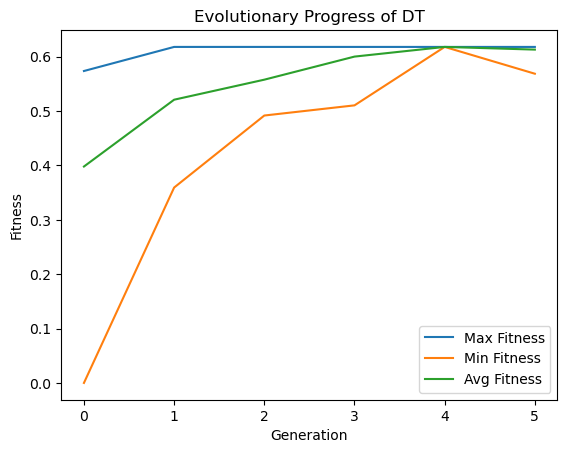

GB
gen	nevals	max   	min	avg    	std     
0  	10    	0.6219	0  	0.47245	0.175185
1  	10    	0.6006	0.4738	0.57169	0.0441556
2  	6     	0.6006	0.5338	0.58625	0.0261773
3  	10    	0.6212	0.6   	0.60448	0.00836431
4  	4     	0.6212	0.6   	0.60872	0.0100702 
5  	6     	0.6212	0.6006	0.61084	0.0102414 


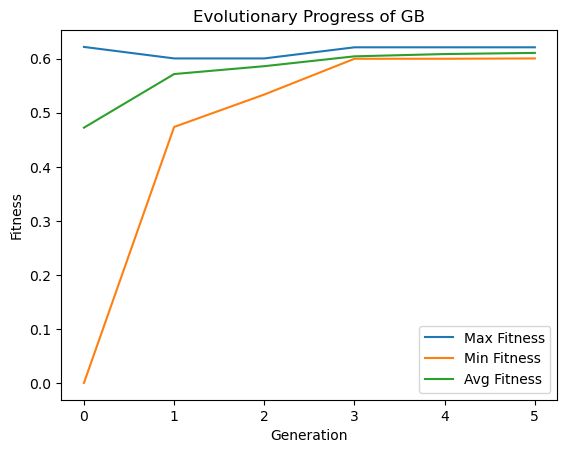

LR
gen	nevals	max   	min   	avg    	std      
0  	10    	0.6062	0.3094	0.53405	0.0853176
1  	8     	0.6131	0.5525	0.59156	0.0154037
2  	8     	0.6262	0.5806	0.59699	0.0139991
3  	6     	0.6262	0.5775	0.6028 	0.0130718
4  	8     	0.6138	0.6025	0.60887	0.00418283
5  	7     	0.6138	0.5638	0.60743	0.014701  


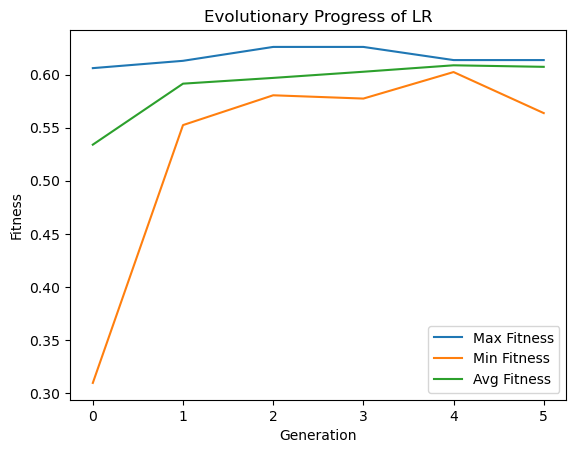

MLP
gen	nevals	max   	min   	avg    	std      
0  	10    	0.6125	0.3794	0.53775	0.0799452
1  	8     	0.6306	0.4288	0.58363	0.0550294
2  	8     	0.6306	0.6106	0.6206 	0.01     
3  	5     	0.6412	0.61  	0.62366	0.0112047
4  	8     	0.6419	0.5019	0.61399	0.0398709
5  	8     	0.6419	0.6306	0.6373 	0.00535668


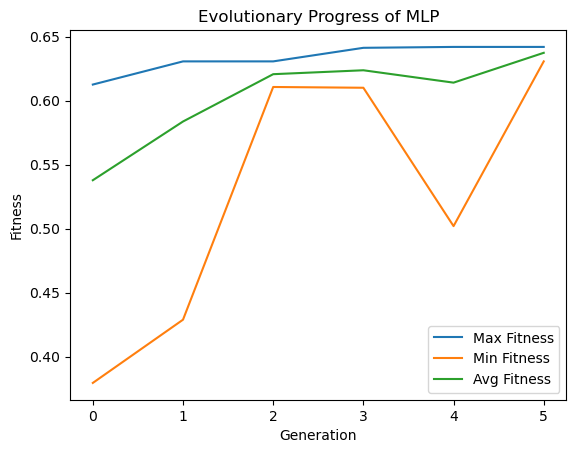

NB
gen	nevals	max   	min	avg    	std     
0  	10    	0.6012	0  	0.46893	0.234751
1  	10    	0.6012	0.575	0.59242	0.00894179
2  	7     	0.6044	0.5819	0.59673	0.00722662
3  	10    	0.6438	0.6006	0.60898	0.0128351 
4  	6     	0.6438	0.5906	0.61356	0.0171403 
5  	8     	0.6438	0.6131	0.63102	0.0119774 


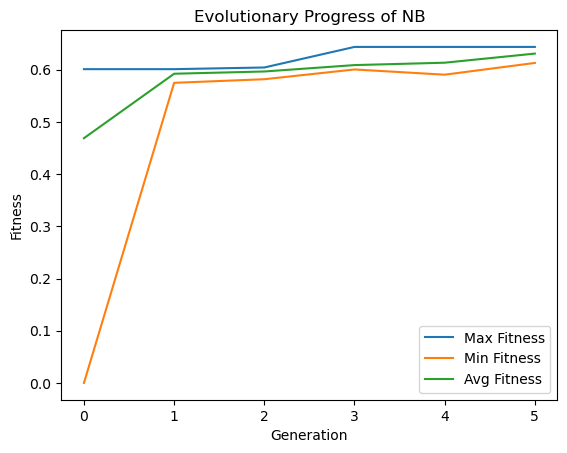

RF
gen	nevals	max   	min   	avg    	std      
0  	10    	0.6606	0.5444	0.60325	0.0390119
1  	7     	0.665 	0.6206	0.64018	0.014251 
2  	7     	0.6606	0.6056	0.64599	0.0160322
3  	7     	0.6606	0.6325	0.65617	0.00925095
4  	4     	0.6606	0.6606	0.6606 	1.11022e-16
5  	6     	0.6606	0.6606	0.6606 	1.11022e-16


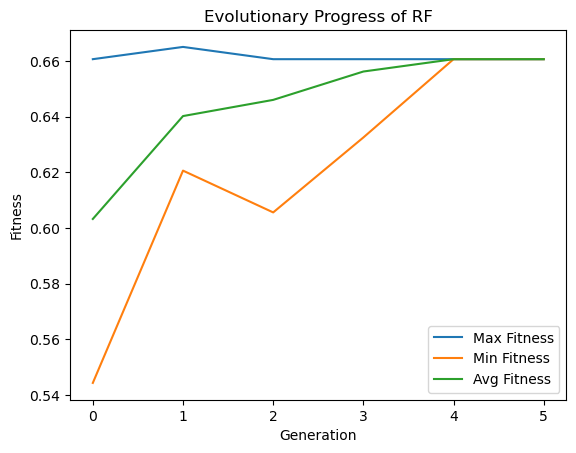

SVM
gen	nevals	max   	min   	avg    	std      
0  	10    	0.5712	0.3894	0.49657	0.0605723
1  	8     	0.6006	0.5306	0.55812	0.021048 
2  	6     	0.6006	0     	0.51537	0.172811 
3  	8     	0.6006	0.5631	0.58599	0.0111238
4  	8     	0.6006	0.5612	0.58761	0.0122597
5  	10    	0.6006	0.4331	0.55754	0.0650244


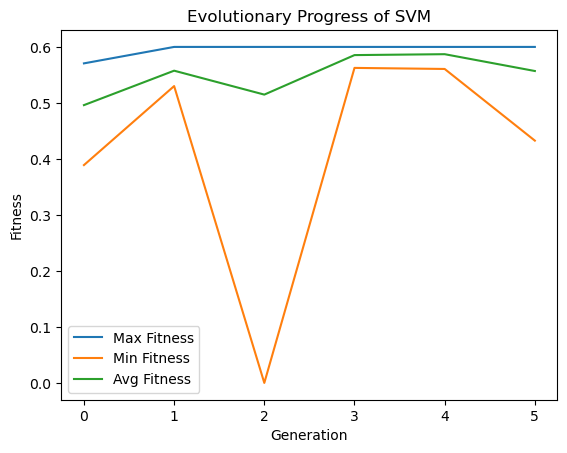

In [12]:
for model_name in model_space: 
    print(model_name)
    # Function to evaluate individuals
    def evaluate(individual):
        threshold = individual[-1]  # O último gene é o limiar
        selected_features = [i >= threshold for i in individual[:-1]]  # Seleciona features com base no limiar
        if not str(selected_features) in evaluations:          
            model_opt = bayes_search(
                model_space[model_name]['model'],
                model_space[model_name]['space'],
                False
            )
            model_opt.fit(X_train.iloc[:,selected_features], y_train)
            performance = round(model_opt.best_score_, 2)
            unused_feat_pct = round((1 - np.mean(selected_features))/100, 4)
            evaluations[str(selected_features)] = performance + unused_feat_pct
        return evaluations[str(selected_features)],

    # Initialize a shared dictionary for evaluations
    manager = multiprocessing.Manager()
    evaluations = manager.dict({str([False] * len(X_train.columns)): 0.0})

    # Create types
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Create stats
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    stats.register("std", np.std)

    # Create toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, MIN_THRESHOLD, MAX_THRESHOLD)  
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=X_train.shape[1] + 1)  # Adicione 1 para o limiar
    toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=POPULATION_SIZE)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=MIN_THRESHOLD, up=MAX_THRESHOLD, eta=0.5, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Process Pool
    cpu_count = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(cpu_count)
    toolbox.register("map", pool.map)

    # Initialize population
    population = toolbox.population()

    # Perform evolutionary algorithm
    population, logbook = algorithms.eaSimple(
        population,
        toolbox,
        cxpb=CROSSOVER_RATE,
        mutpb=MUTATION_RATE,
        ngen=GENERATIONS,
        stats=stats,
        verbose=True
    )

    # Save evaluations
    file_path = f'{directory_evaluations}/{model_name}.csv'
    with open(file_path, 'w', newline='') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['Features', 'Fitness'])
        for key, value in evaluations.items():
            features = list(X_train.columns[ast.literal_eval(key)])
            csv_writer.writerow([features, value])

    # Accessing the evolution statistics
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")
    min_fitness = logbook.select("min")
    avg_fitness = logbook.select("avg")

    # Plotting the evolution statistics
    plt.plot(gen, max_fitness, label="Max Fitness")
    plt.plot(gen, min_fitness, label="Min Fitness")
    plt.plot(gen, avg_fitness, label="Avg Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"Evolutionary Progress of {model_name}")
    plt.legend()

    # Save the plot as an image
    plt.savefig(f'{directory_plots}/Evolutionary Progress of {model_name}.png')

    # Show the plot
    plt.show()

# SAVE MODELS

In [18]:
def best_features_set(model_name):
    evaluations_folder = '../evaluations/'
    evaluations = pd.read_csv(f'{evaluations_folder}/{model_name}.csv')
    evaluations['feature_count'] = evaluations['Features'].apply(lambda x: len(ast.literal_eval(x)))
    evaluations_sorted = evaluations.sort_values(by=['Fitness', 'feature_count'], ascending=[False, True])
    index_max_fitness_min_features = evaluations_sorted.index[0]
    best_features = evaluations_sorted.loc[index_max_fitness_min_features, 'Features']
    return ast.literal_eval(best_features)

In [19]:
for model_name in model_space:
    model_opt = bayes_search(
        model_space[model_name]['model'],
        model_space[model_name]['space'])
    features = best_features_set(model_name)
    model_opt.fit(X_train.loc[:,features],y_train)
    print(f'{model_name}: {features} -> {model_opt.best_score_}')
    model_path = f'{directory_models}/{model_name}.joblib'
    dump(model_opt.best_estimator_, model_path)

DT: ['IPAQ-SF', 'MNA-SF', 'Advanced Staging'] -> 0.6064159316177757
GB: ['CCI', 'GDS-SF', 'IPAQ-SF', 'KATZ', 'KPS', 'MMSE', 'MNA-SF', 'TUG', 'Hemoglobin', 'Leukocyte', 'Platelet', 'Creatinine', 'Advanced Staging'] -> 0.6204651660688812
LR: ['Gender', 'CCI', 'IPAQ-SF', 'KPS', 'TUG', 'Advanced Staging'] -> 0.6160316312365041
MLP: ['Gender', 'CCI', 'GDS-SF', 'IPAQ-SF', 'KATZ', 'KPS', 'MNA-SF', 'Polypharmacy', 'TUG', 'Leukocyte', 'Platelet', 'Creatinine', 'Advanced Staging'] -> 0.6444063478661002
NB: ['Gender', 'CCI', 'MMSE', 'MNA-SF', 'Polypharmacy', 'Hemoglobin', 'Leukocyte', 'Platelet', 'Creatinine', 'Advanced Staging'] -> 0.6437154874709055
RF: ['Gender', 'IPAQ-SF', 'KPS', 'Polypharmacy', 'TUG', 'Hemoglobin', 'Leukocyte', 'Advanced Staging'] -> 0.6635278928158185
SVM: ['Age', 'Gender', 'GDS-SF', 'IPAQ-SF', 'KATZ', 'KPS', 'MMSE', 'MNA-SF', 'Polypharmacy', 'TUG', 'Hemoglobin', 'Leukocyte', 'Platelet', 'Creatinine', 'Advanced Staging'] -> 0.5994537655327129
